In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import pandas as pd
import transformers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from llm_style.formality_dataset import FormalityDataset, PavlickFormalityDataset
from llm_style.domain_dataset import DomainDataset, DomainType


In [2]:
dataset = DomainDataset(mode="int")

In [3]:
pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use mps


In [4]:
# Get device for computation
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Extract texts and labels from the dataset
texts = []
labels = []
for i in range(0, 250):
    # if i >= len(dataset):
    #     break
    sample = dataset[i]
    if "text" not in sample or "label" not in sample:
        print(f"Skipping index {i} due to missing fields.")
        continue
    texts.append(sample["text"])
    labels.append(sample["label"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)


# Define a function to extract features from text
def extract_features(model, tokenizer, texts, layer_idx):
    # Move model to the correct device if not already there
    # model_device = next(model.parameters()).device
    # if model_device != device:
    #     model = model.to(device)

    features = []
    batch_size = 16  # Adjust based on your GPU/memory

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        # Tokenize the texts
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get model outputs with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract hidden states from the specified layer
        # For phi-4 model, access the proper hidden states format
        if hasattr(outputs, "hidden_states"):
            hidden_states = outputs.hidden_states[layer_idx]
        else:
            # If hidden_states is a tuple, access it directly
            hidden_states = outputs[2][layer_idx]
        hidden_states = hidden_states.to(torch.float32)

        # Average across the token dimension to get a fixed-size representation
        batch_features = hidden_states.mean(dim=1)
        batch_features_cpu = batch_features.cpu().numpy()
        features.append(batch_features_cpu)

    return np.vstack(features)



Using device: mps


In [5]:
class LatentBottleneck(nn.Module):
    def __init__(self, dim_model: int, dim_latent: int):
        super().__init__()
        self.down = nn.Linear(dim_model, dim_latent)
        self.up = nn.Linear(dim_latent, dim_model)

    def forward(self, x):
        return self.up(self.down(x))

    def forward_latent(self, x):
        return self.down(x)

class LatentClassifier(nn.Module):
    def __init__(self, bottleneck: LatentBottleneck, num_classes: int):
        super().__init__()
        self.bottleneck = bottleneck
        self.classifier = nn.Linear(bottleneck.down.out_features, num_classes)

    def forward(self, x):
        latent = self.bottleneck.forward_latent(x)
        return self.classifier(latent)

class ResidualBottleneckWrapper(nn.Module):
    def __init__(self, layer: nn.Module, dim_model: int, dim_latent: int):
        super().__init__()
        self.layer = layer
        self.bottleneck = LatentBottleneck(dim_model, dim_latent)

    def forward(self, x, *args, **kwargs):
        bottleneck_out = self.bottleneck(x)
        x_modified = x + bottleneck_out
        return self.layer(x_modified, *args, **kwargs)

# Example: bottleneck from original 5120
bottleneck = LatentBottleneck(dim_model=5120, dim_latent=32)

In [6]:
# Freeze all layers except the bottleneck
for param in pipeline.model.parameters():
    param.requires_grad = False
for param in bottleneck.parameters():
    param.requires_grad = True
# Insert the bottleneck into the model

# Wrap layer 21 in a residual bottleneck
original_layer = pipeline.model.model.layers[21]
dim_model = 5120
dim_latent = 6
wrapped_layer = ResidualBottleneckWrapper(original_layer, dim_model, dim_latent)
wrapped_layer = wrapped_layer.to_empty(device=device)

# Replace in-place
pipeline.model.model.layers[21] = wrapped_layer

In [7]:
# Print all the layers and the count of their params:
def print_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Params: {param.numel()}")
print_layers(pipeline.model)

Layer: model.layers.21.bottleneck.down.weight, Params: 30720
Layer: model.layers.21.bottleneck.down.bias, Params: 6
Layer: model.layers.21.bottleneck.up.weight, Params: 30720
Layer: model.layers.21.bottleneck.up.bias, Params: 5120


In [8]:
# Now we'll train the bottleneck to one-hot the label
def train_latent_classifier(
    model: nn.Module,
    llm: nn.Module,
    tokenizer,
    X_train,
    y_train,
    layer_idx=21,
    epochs=5,
    batch_size=16,
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1 * 10**(-3.5))
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_texts = X_train[i : i + batch_size]
            batch_labels = y_train[i : i + batch_size]

            # Tokenize
            inputs = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512,
            ).to(device)

            # Forward through frozen LLM to get hidden states
            with torch.no_grad():
                outputs = llm(**inputs, output_hidden_states=True)
                hidden_states = outputs.hidden_states[layer_idx]
                x = hidden_states.mean(dim=1).to(torch.float32).to(device)

            # Forward through latent classifier
            labels_tensor = torch.tensor(batch_labels, device=device)
            preds = model(x)
            loss = criterion(preds, labels_tensor)

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Batch {i//batch_size+1}, Loss: {loss.item():.4f}")
        print(f"Epoch {epoch+1} completed.")

In [9]:
# Train the bottleneck
latent_classifier = LatentClassifier(bottleneck, num_classes=len(set(y_train))).to(device)
train_latent_classifier(
    latent_classifier,
    pipeline.model,
    pipeline.tokenizer,
    X_train,
    y_train,
    layer_idx=21,
    batch_size=32,
)

Epoch 1, Batch 1, Loss: 1.3987
Epoch 1, Batch 2, Loss: 1.0592
Epoch 1, Batch 3, Loss: 1.0469
Epoch 1, Batch 4, Loss: 0.8706
Epoch 1, Batch 5, Loss: 1.2054
Epoch 1, Batch 6, Loss: 1.3611
Epoch 1, Batch 7, Loss: 0.9126
Epoch 1 completed.
Epoch 2, Batch 1, Loss: 0.8472
Epoch 2, Batch 2, Loss: 0.8058
Epoch 2, Batch 3, Loss: 0.9579
Epoch 2, Batch 4, Loss: 0.6355
Epoch 2, Batch 5, Loss: 0.7337
Epoch 2, Batch 6, Loss: 0.7922
Epoch 2, Batch 7, Loss: 0.7045
Epoch 2 completed.
Epoch 3, Batch 1, Loss: 0.6261
Epoch 3, Batch 2, Loss: 0.5726
Epoch 3, Batch 3, Loss: 0.6875
Epoch 3, Batch 4, Loss: 0.4951
Epoch 3, Batch 5, Loss: 0.5972
Epoch 3, Batch 6, Loss: 0.6640
Epoch 3, Batch 7, Loss: 0.2442
Epoch 3 completed.
Epoch 4, Batch 1, Loss: 0.4386
Epoch 4, Batch 2, Loss: 0.4795
Epoch 4, Batch 3, Loss: 0.6342
Epoch 4, Batch 4, Loss: 0.4456
Epoch 4, Batch 5, Loss: 0.5745
Epoch 4, Batch 6, Loss: 0.5205
Epoch 4, Batch 7, Loss: 0.1560
Epoch 4 completed.
Epoch 5, Batch 1, Loss: 0.3635
Epoch 5, Batch 2, Loss: 0

In [10]:
def predict_domain(text: str, llm, tokenizer, classifier, layer_idx=21):
    classifier.eval()

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = llm(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx]
        x = hidden_states.mean(dim=1).to(torch.float32).to(device)

        logits = classifier(x)
        predicted_class = logits.argmax(dim=1).item()

    return DomainType.from_int(predicted_class), logits

In [11]:
text = "I'd try unplugging your modem first to see if that's the problem."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: blog


In [12]:
text = "When I first set out on this vacation, I was worried my shoes wouldn't last."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: blog


In [13]:
text = "You need to send me the report by the end of the day."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: email


In [14]:
text = "In breaking news, a major earthquake has struck the city, causing widespread damage and panic."
pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
print(f"Predicted domain class: {pred}")

Predicted domain class: news


In [15]:
# Confusion matrix:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [16]:
# Evaluate the model on the test set
y_pred = []
for text in X_test:
    pred, _ = predict_domain(text, pipeline.model, pipeline.tokenizer, latent_classifier, layer_idx=21)
    y_pred.append(pred)


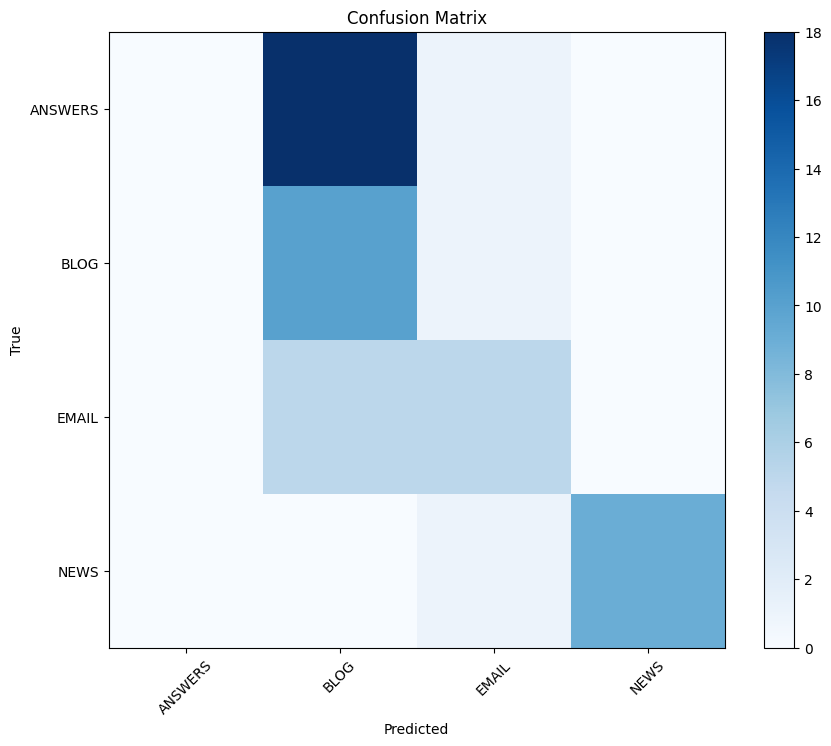

Accuracy: 0.4800


In [17]:
# Plot confusion matrix
plot_confusion_matrix(y_test, [DomainType.as_int(y) for y in y_pred], [
"ANSWERS",
"BLOG",
"EMAIL",
"NEWS",
])
# Print accuracy
accuracy = accuracy_score(y_test, [DomainType.as_int(y) for y in y_pred])
print(f"Accuracy: {accuracy:.4f}")

## Content Evaluation

In [20]:
from datasets import Dataset
!uv add evaluate
import evaluate
from tqdm.auto import tqdm
import math
from llm_style.content_dataset import CNNContentDataset

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to parse lockfile; ignoring locked requirements: TOML parse error at line 432, column 1
    |
432 | <<<<<<< HEAD
    | ^
invalid key
Resolved 131 packages in 910ms                                       
Building llm-style @ file:///Users/mateljk1/Documents/school/S25/ATDL/llm_style
Building llm-style @ file:///Users/mateljk1/Documents/school/S25/ATDL/llm_style
⠙ Preparing packages... (0/31)
Building llm-style @ file:///Users/mateljk1/Documents/school/S25/ATDL/llm_style
⠙ Preparing packages... (0/31)
setuptools ------------------------------     0 B/1.26 MB
Building llm-style @ file:///Users/mateljk1/Documents/school/S25/ATDL/llm_style
⠙ Preparing packages... (0/31)
setuptools ------------------------------     0 B/1.26 MB
Building llm-style @ file:///Users/mateljk1/Documents/school/S25/ATDL/llm_style
⠙ Preparing packages... (0/31)
multidict  ------------------------------     0 B/37.71 kB
setuptools ------------------------------     0 B/1.26 MB
Building llm-style @ file:///User

In [21]:
# Initialize the CNNContentDataset
cnn_dataset = CNNContentDataset()


print(f"Number of samples in CNN dataset: {len(cnn_dataset)}")
# Print the first 5 samples
for i in range(5):
    sample = cnn_dataset[i]
    print(f"Sample {i}:", sample)

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Number of samples in CNN dataset: 287113
Sample 0: {'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places b

In [22]:
# Define the device for computation.
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Create a baseline text-generation pipeline from the original phi-4 model.
baseline_pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",  # original model without your modifications
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto"
)

Using device: mps


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.
Device set to use mps


In [29]:
total_samples = len(cnn_dataset)
subset_size = int(total_samples * 0.005)
# Build a list of samples from the first subset_size indices.
subset = [cnn_dataset[i] for i in range(subset_size)]
print(f"Using a subset of {subset_size} samples (.5% of dataset).")

# Print the type and content of the first sample.
first_sample = subset[0]
print("First sample type:", type(first_sample))
print("First sample content:", first_sample)


Using a subset of 1435 samples (.5% of dataset).
First sample type: <class 'dict'>
First sample content: {'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the

In [ ]:
baseline_predictions = []
modified_predictions = []
references = []

# Loop over each sample in the subset with a progress bar.
for sample in tqdm(subset[10:20], desc="Evaluating samples"):
    print("Sample:", sample)
    article = sample["article"]
    reference_summary = sample["summary"]

    # print("Baseline out...")
    # Generate summary using the baseline (original phi-4) model.
    baseline_out = baseline_pipeline(
        article,
        max_new_tokens=10,
        min_new_tokens=0,
        # do_sample=False,
        # truncation=True
    )
    # print("Baseline out:", baseline_out)
    baseline_summary = baseline_out[0].get("summary_text", baseline_out[0].get("generated_text", ""))

    # Generate summary using the modified (fine-tuned) model.
    # print("Modified out...")
    modified_out = pipeline(
        article,
        max_new_tokens=10,
        min_new_tokens=0,
        # do_sample=False,
        # truncation=True
    )
    modified_summary = modified_out[0].get("summary_text", modified_out[0].get("generated_text", ""))

    baseline_predictions.append(baseline_summary)
    modified_predictions.append(modified_summary)
    references.append(reference_summary)

# Load the ROUGE evaluation metric.


Evaluating samples:   0%|          | 0/10 [00:00<?, ?it/s]

Sample: {'article': 'WASHINGTON (CNN) -- As he awaits a crucial progress report on Iraq, President Bush will try to put a twist on comparisons of the war to Vietnam by invoking the historical lessons of that conflict to argue against pulling out. President Bush pauses Tuesday during a news conference at the  North American Leaders summit in Canada. On Wednesday in Kansas City, Missouri, Bush will tell members of the Veterans of Foreign Wars that "then, as now, people argued that the real problem was America\'s presence and that if we would just withdraw, the killing would end," according to speech excerpts released Tuesday by the White House. "Three decades later, there is a legitimate debate about how we got into the Vietnam War and how we left," Bush will say. "Whatever your position in that debate, one unmistakable legacy of Vietnam is that the price of America\'s withdrawal was paid by millions of innocent citizens, whose agonies would add to our vocabulary new terms like \'boat pe

ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['absl', 'rouge_score'] using 'pip install # Here to have a nice missing dependency error message early on rouge_score' for instance'

In [48]:
# Dump the results to JSON so we can use them later.
import json
with open("rouge_results.json", "w") as f:
    json.dump({
        "baseline_predictions": baseline_predictions,
        "modified_predictions": modified_predictions,
        "references": references
    }, f, indent=4)
# Evaluate the baseline model's predictions.

In [46]:
!uv add absl rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  × No solution found when resolving dependencies for split                         
  │ (python_full_version == '3.11.*'):
  ╰─▶ Because there are no versions of absl and your project depends on absl,
      we can conclude that your project's requirements are unsatisfiable.
  help: If this is intentional, run `uv add --frozen` to skip the lock and
        sync steps.


Loading ROUGE metric...


ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['absl', 'rouge_score'] using 'pip install # Here to have a nice missing dependency error message early on rouge_score' for instance'

# Steering

In [25]:
# Hard-code the style latent and see how it affects the output.
# In other words, we want to see if we can get the model to generate a specific style of text.
# To do this, we need to set the style latent to a specific value, do a forward pass through the model,
# and keep the latent fixed (i.e., don't allow it to be updated at each step).

def generate_with_fixed_latent(
    model: nn.Module,
    tokenizer,
    text: str,
    style_latent: torch.Tensor,
    layer_idx=21,
    max_new_tokens=130,
    min_new_tokens=30,
    do_sample=False,
    truncation=True,
    **kwargs
):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=truncation,
        max_length=512,
    ).to(device)
    # Get the hidden states from the model
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[layer_idx]
        x = hidden_states.mean(dim=1).to(torch.float32).to(device)
    # Get the style latent from the bottleneck
    style_latent = style_latent.to(device)
    # Get the logits from the model
    style_layer = model.model.layers[layer_idx]
    logits = style_layer.bottleneck.up(style_latent)
    # Get the logits from the model
    logits = style_layer(x)
    # Generate the output text
    generated_ids = model.generate(
        inputs.input_ids,
        max_new_tokens=max_new_tokens,
        min_new_tokens=min_new_tokens,
        do_sample=do_sample,
        logits_processor=logits,
        **kwargs
    )
    # Decode the generated text
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text



In [26]:
generated_text = generate_with_fixed_latent(
    model=pipeline.model,
    tokenizer=pipeline.tokenizer,
    text="Your input text here",
    style_latent=torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),  # Example style latent
)

TypeError: cannot unpack non-iterable NoneType object